<a href="https://colab.research.google.com/github/eliasrahimi/Hello-world/blob/master/Inl%C3%A4mning_Lab4_Clustering_and_Association_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Klustring och Associationsanalys 


I denna labb ska ni använda två olika typer av oövervakad inlärning för att analysera transaktionsdata.

I del 1 kommer ni analysera data från genom så kallad RFM analysis, vi kommer genomföra analysen med hjälp a en K-means modell i Python för att klustra data beroende på det mönster som uppvisas i data, baserat på just RFM.

I del 2 ska ni få testa på associationsanalys genom att  analysera transaktionsdata från matvaruhandeln, närmare bestämt för en butik kallad *MatFörAlla* för att på detta sätt komma med råd för hur de bör organisera sin butik för att öka försäljningen. 

Till skillnad från flera av de tidigare laborationerna kommer fokus här inte vara så mycket på programmeringen, utan mycket kod kommer redan finnas i laborationen. Fokus är snarare på att förstå de baokmliggande mekanismerna i denna typ av dataanalys som skiljer sig från de vi tidigare tittat på. 


## Del 1 Klustring

Inspirerad av: Khalid i Towards Data Science

I denna del av laborationen ska ni använda ett dataset med data från en onlineaffär för att lista ut vilka olika kunder ni har- Vilka är exempelvis lojala kunder,som ni bör ägna extra energi åt, och vilka är sådana som bara handlar någon enstaka gång och som det inte är värt att lägga tid och pengar på? Vi ska alltså segmentera våra kunder baserat på några olika kriterier. Själva segmenteringen kommer vi utföra med K-means clustering. 

Det finns många olika sätt att segmentera kunder på, några man kan tänka sig är:

* Demografiskt - ålder, kön etc. Demographic — age, gender, socioeconomic status
* Geografiskt - var de borGeographic — where in the world are they?
* **Beteendemässigt - vad gör dina kunder på din sida?** 

I denna laboration  ska vi segmentera kunder baserat på beteende. Ett vanligt sätt att fånga beteende är genom så kallad RFM segmentering, vilket innebär att kunder segmenteras baserat på tre kriterier nämligen *Recency, Frequency and Monetary*, alltså **RFM**. 

* Recency - antalet dagar sedan en kund köpte något.
* Frequency - Hur ofta en kund handlar
* Monetary - För hur mycket har kunden handlat för?





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

**F1** Ni kan själva hämta det dataset ni ska använda [här](https://archive.ics.uci.edu/ml/datasets/online+retail) där finns också värdefull information om kvaliteten på detta dataset. 

In [ ]:
import io

In [ ]:
from pandas import read_excel

In [ ]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

In [ ]:
df = df[df['CustomerID'].notna()]

Vi kommer inte använda hela detta dataset då det är extremt stort, vilket gör att det blir för tungt att arbeta med. Istället väljer vi ut 10000 rader som får representera våra kunders beteende.

In [ ]:
df_fix = df.sample(10000, random_state = 42)
df_fix.shape

(10000, 8)

In [ ]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom


Som vanligt behöver vi först bekanta oss med den data vi har tillgänglig och även kontrollera om vi behöver åtgärda något innan vi påbörjar analysen. 

Följande punkter är krav som behöver säkerställas för att K-means ska fungera på ett dataset. 

**Inga nullvärden** K-means kan inte hantera nullvärden överhuvudtaget så de måste antingen ersättas eller så måste hela raden tas bort. 

**Endast numeriska värden.** Eftersom K-means använder distans som beräkningssätt för att hitta kluster fungerar inte kategoriska variabler. Dessa behöver därför ersättas, antingen med numeriska värden, om de tillhör ordnialskala (och därmed har ordning) eller med dummyvariabler om de tillhör nominalskala och alltså inte har någon ordning. Mycket viktigt att inte distanser förändras!

**Inga outliers eller brus.** K-means är väldigt känslig för detta.

**Det finns ingen/liten korrelation mellan variablerna** Korrelerade variabler är att betrakta som brus och är inte meningsfulla för algoritmer som ska dela in data i olika segment eftersom de representerar samma karaktäristik hos ett segment. Variabler med hög korrelation mellan varandra bör alltså inte båda inkluderas.

**Inte för många dimensioner.** När antalet dimensioner (variabler) ökar, kommer distansen mellan alla variabler att konvergera till ett konstant värde mellan vilka variabler som helst, därmed kan man inte längre urskilja några kluster. Ju fler dimensioner, desto svårare att hitta kluster alltså. 

Det finns också några till, men de kommer vi till senare.



**F2** 

>
>a. Är det någon av dessa krav som **inte** är uppfyllda? Motivera svaret.
>
>b. Hantera eventuella nullvärden på lämpligt sätt.

In [ ]:
df_fix.isnull().sum()
#Inga null värden

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [ ]:
df_fix.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
#Som vi ser finns det inte enbart numeriska värden.

InvoiceNo      False
StockCode      False
Description    False
Quantity        True
InvoiceDate     True
UnitPrice       True
CustomerID      True
Country        False
dtype: bool

In [ ]:
# Outlier detection 
from collections import Counter
#Once initialized, counters are accessed just like dictionaries.
#Also, it does not raise the KeyValue error (if key is not present) instead the value’s count is shown as 0.
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df,2,[])
df.loc[Outliers_to_drop] # Show the outliers rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
#Inga tydliga outliers existerar

In [ ]:
df_fix.corr()

In [ ]:
#Ingen tydlig korrelation

In [ ]:
df_fix.ndim

In [ ]:
df_fix.shape

In [ ]:
#Inte så många dimensioner

In [ ]:
#F2b finns inga nullvärden att radera

### RFM

För att segmentera våra kunder ka vi alltså använda RFM,vilket betyder att vi behöver skapa dessa features (kolumner) för att kunna klustra dem i enlighet med dessa. Vi behöver såklart utgå från det data vi har för att skapa dessa tre kolumner. Detta görs i koden nedan. 

**F3** Kommentera koden så att det är förståeligt vad som händer. 

In [ ]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07,7.95,13534.0,United Kingdom,15.9
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15,3.95,14894.0,United Kingdom,15.8
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03,0.85,12921.0,United Kingdom,-3.4
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04,1.65,17229.0,United Kingdom,6.6
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08,0.55,15144.0,United Kingdom,13.2


In [ ]:
from datetime import datetime,timedelta # Convert to show date only
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date
#extraherar datum och ersätter med datum.# Create TotalSum colummn

df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]
#Räknar ut den totala summan beroende på kvanitet och pris för produkt.
# Create date variable that records recency

snapshot_date = max(df_fix.InvoiceDate) + timedelta(days=1)
#tilldelar snapshot_date största datumet för InvoiceDate + en dag
# Aggregate data by each customer

customers = df_fix.groupby(['CustomerID']).agg({
   'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
#InvoiceDate får ett aktualitetsvärde
#InvoiceNo räknar ut frekvensen för fakturor
#TotalSum ger den totala summan
# Rename columns

customers.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,2
12348.0,249,2,120.88,1
12349.0,19,2,312.75,2
12352.0,73,5,80.85,2
12354.0,233,2,33.30,1


Förutom de krav som diskuterats ovan kräver också K-means att data skalas och transformeras så att det är normalfördelat och standardiserat. 

**Symetrisk distribution av variabler i data (ingen skevhet).** Transformering av data till en normal distribution medför att outliers och brus från mindre påverkan. 

**Variabler i samma skala** — Alltså ha samma medelvärde och varians, vanligtvis vill man ha värden mellan -1 till 1 (standardiserad data) eller mellan 0 till 1 (normliserad data). För att K-means ska behandla alla attribut som likvärdiga måste de ha samma skala. 

I nedanstående kodblock följer en ananlys för att ta reda på hur våra RFM-variabler ser ut.

Vi startar med att titta på hur de tre variablerna ser ut.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

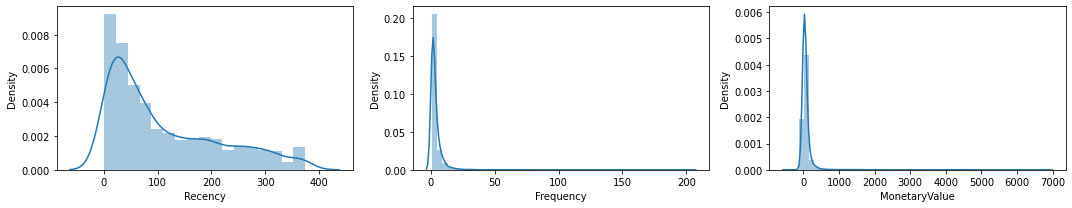

In [ ]:
#Visualisera distributionen av data i våra tre variabler 
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

**F4** Hur ser vår data ut? Är de tre variablernas distribution symetrisk?

In [ ]:
#Nej, det finns värden som aviker vilket man ser på stapeldiagramen som inte riktigt följer linjerna

In [ ]:
customers.Frequency.describe()

count    2690.000000
mean        3.717472
std         7.176189
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       203.000000
Name: Frequency, dtype: float64

In [ ]:
customers.Frequency.describe()

count    2690.000000
mean        3.717472
std         7.176189
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       203.000000
Name: Frequency, dtype: float64

In [ ]:
customers.Recency.describe()

In [ ]:
#Vi ser att mean aviker en del från 50% kvartilen. 

För att ytterligare undersöka skevheten kan vi också använda pandas inbyggda funktion för det `pd.skew()`. 

Det går inte att säga exakt vilket värde som reflekterar symmentri även fast man tycka att ett värde på 0 torde göra det, men  det kan också implicera att den ena sidan är "tjock" och den andra "tunn". En tumregel är dock att ett positivt värde indikerar en positiv skevhet, (alltså att värdena tenderar att vara fler över 0 jämfört med under 0) medan ett negativt värde indikerar en negativ skevhet.

Anledningar till skevhet kan vara outliers, men det behöver inte vara så. 

**F5** Följande kod hanterar de problem som finns gällande skevheten i de tre variablerna. Hur har skevheten hos de tre variablerna förändrats efter transformeringen?

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [ ]:
print(customers['Recency'].skew().round(2))
print(customers['Frequency'].skew().round(2))
print(customers['MonetaryValue'].skew().round(2)) 

0.93
14.77
16.63


In [ ]:
#före = Postiv skevhet

In [ ]:
print(customers_fix['Recency'].skew().round(2))
print(customers_fix['Frequency'].skew().round(2))
print(customers_fix['MonetaryValue'].skew().round(2)) 

-0.1
0.16
1.16


In [ ]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

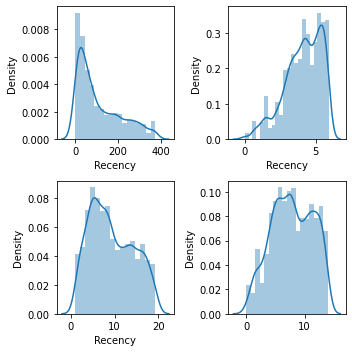

0.93
-0.72
0.32
-0.1


In [ ]:
analyze_skewness('Recency')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

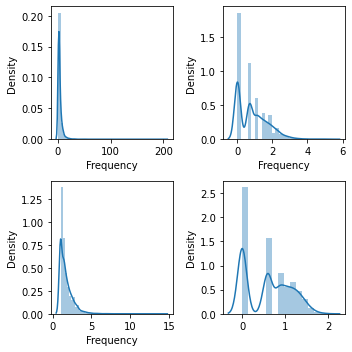

14.77
0.85
3.67
0.16


In [ ]:
analyze_skewness('Frequency')

In [ ]:
#Mycket närmre 0 och mer normalfördelad

In [ ]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [ ]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


Genom att använda transformationen kommer vi att ha data som är mindre skewd. Vi behöver omvandla RFM-tabellen.

Vi behöver också se till att kravet på variablerna att befinna sig i samma skala uppfylls. Det görs i nedanstående kod. 

**F6** 

>
>a. Vilken typ av transformering har gjorts? Varför?
>
>b. Visualisera resultatet
>
>c. Varför är det så viktigt i K-means att denna pre-processing görs?
>
>d. Vad för struktur är customers_normalized?

Om vi tittar på plot har inte varje variabel samma medelvärde och varians. Vi måste normalisera det. För att normalisera kan vi använda StandardScaler-object för att göra det.Men koden nedan gör det. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


In [ ]:
pd.DataFrame(customers_normalized).head()
# Data kommer att se ut så här nu., slutligen kan vi göra kluster genom att använda dessa data.

,0,1,2
0,-0.493794,1.012426,1.017503
1,1.232949,-0.017412,0.925115
2,-0.994917,-0.017412,1.972690
3,-0.012582,1.012426,0.572565
4,1.155005,-0.017412,-0.056441


In [ ]:
customers_normalized.ndim

2

In [ ]:
# StandardScaler har tillämpats här och har tagit bort medianen för dataframe. Denna metod fungerar sämre vid outliers, men i vårt dataset har vi inte några sådana från vad vi har sett. 
# StandardScaler minskar spektrummet för värden vilket gör de mer hanterabara för linjära preditkioner och för tillämpning av andra algoritmer som är intoleranta mot starka avikelser.

Nu är det dags att testa att använda K-means för att segmentera våra kunder. Efter pre-processing av data kan vi nu fokusera på modellering. För att göra segmentering från data som vi har kan vi använda K_means-algoritmen för att göra detta.K_means algoritmen använder den geometriska principen för att bestämma vilka data som ska tillhöra en kluster. Genom att välja varje Centroid beräknar vi avståndet till varje Centroid.  Varje värde tillhör en Centroid om den har det minsta avståndet från den andra. Det uppreps tills nästa totala avstånd inte har betydande förändringsavstånd än tidigare. För att vårt klustring ska nå maximalt prestanda måste vi avgöra vilken hyperparametrar som passar vår data. För att avgöra vilken hyperparametrar som är bäst för vår modell och data kan vi använda armbågsmodellen för att göra det. koden nedan gör klustrering åt oss. 

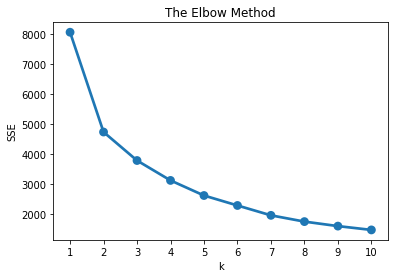

In [ ]:
from sklearn.cluster import KMeans

sse = {} #sum of squared error
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
#f6c för att lättare kunna identifiera kundsegment och gruppera vår data. K-means är också en av de mest effetkiva metoderna för gruppering av data då den även är enkel att implementera.

In [ ]:
#f6d en arraystruktur.

**F7** 

>a. Vilket k är lämpligast enligt armbågsmetoden? Varför?
>
>b. Fyll i detta tal i nedanstående kod som skapar modellen genom att ersätta punkterna med rätt siffra.

X-axeln visar k-värdet och y-axeln SSE-värdet för datan. Vi tar den bästa parametern genom att titta på  at where the k-value will have a liner trend on the next consecutive k. Baserat på vår observation är k-värdet 3 den bästa hypotesparametern för vår modell eftersom nästa k-värdet tenderar att ha en linjär trend. Därför är vår bästa modell för data K-medel med antal kluster är 3.

In [ ]:
#en allmän tumregel för att välja värdet på k är k = sqrt (N) / 2 , där N står för antalet prover.
#Det optimala K-värdet som vanligtvis finns är kvadratroten av N, där N är det totala antalet prover.
# i detta fall  blir det sqrt √10 = 3.16. 
#k = n ^ (1/2)--- k = 10 ^ (1/2) = 3.16


In [ ]:
model = KMeans(n_clusters= 3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [ ]:
customers.shape

(2690, 4)

Genom att anpasaa modellen kan vi ha kluster där data hör till. Genom det kan vi analysera data.

### Vad säger vår modell?

För att undersöka vad vi fått för kluster kan vi räkna ut medelvärdena för våra skapade kluster. Först lägger vi dock till en kolumn för våra kluster i vår dataframe.

Vi kan också visualisera våra kluster för att få en tydligare bild av dem.

>
>a. Vad säger dessa värden om våra kunder?
>
>b.Vad betyder värdena i den sista kolumnen, som också är ny?
>
>c. Vad säger visualiseringen?
>
>d.Baserat på vad vi nu vet, döp de kluster som skapats till lämpliga namn och skriv en kort rekommendation till butiken hur de bör hantera dem.

Tolkning av segmentet. Vi kan sammanfatta RFM-tabellen baserat på kluster och beräkna medelvärdet för varje variabel. Koden nedan visar det. Förutom det kan vi analysera segmentet med hjälp av plottning. Det kräver normaliserade dataset och även klustetiketter. Genom att använda denna plot kan vi få en bra visualisering från data om hur klustret skiljer sig från varandra. koden nedan visar det.

Cluster **Analysis**

In [ ]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,2
12348.0,249,2,120.88,1
12349.0,19,2,312.75,2
12352.0,73,5,80.85,2
12354.0,233,2,33.30,1


In [ ]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          47.3       1.6          21.6   808
1         226.8       1.6          28.7   959
2          46.3       7.7         165.9   923

In [ ]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.493794,1.012426,1.017503,12347.0,2
1,1.232949,-0.017412,0.925115,12348.0,1
2,-0.994917,-0.017412,1.972690,12349.0,2
3,-0.012582,1.012426,0.572565,12352.0,2
4,1.155005,-0.017412,-0.056441,12354.0,1


In [ ]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-0.493794
1,12348.0,1,Recency,1.232949
2,12349.0,2,Recency,-0.994917
3,12352.0,2,Recency,-0.012582
4,12354.0,1,Recency,1.155005


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


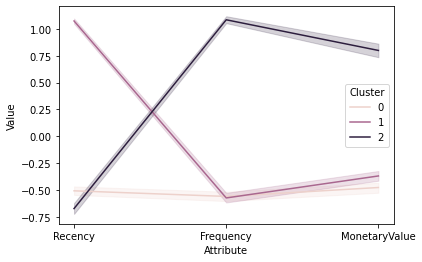

In [ ]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

Genom att använda denna plot vet vi hur varje segment skiljer sig.Vi drar slutsatsen att kluster 0, är frekvent,där kunder spenderar mer pengar och de har köpt produkter nyligen. Därför kan det vara ett kluster av lojala kunder. 
Då är kluster 1, mindre frekvent, mindre pengar att spendera, men de har också köpt produkter nyligen. Där kan det vara kluster av nya kunder. 
Slutligen är kluster 2, mindre frekvent, mindre pengar att spendera och de  har köpt produkter förr. Därför kan det vara kluster av Churned customer.

*Skriv din rekommendation för de namngivna klustren i denna markdown,ersätt denna text.*

Rekommendationer, sammanfattningsvis är kundsegmentering verkligen nödvändig för att veta vilka egenskaper som finns hos varje kundsegment.Ur ett strategiskt perspektiv kan det vara smart att göra en kundsegmentering. Bland annat för att till exempel planera hur ni vill få er verksamhet att växa. Det går även att använda segmentering i syfte att  bedöma potential och affärsvärde på er marknad.

## Del 2 Associationsanalys 

Inspirerad av: David Johnsson

Associationsanalys är en oövervakad analysmetod som går ut på att hitta relationer i data. Ett open source bibliotek som har funktioner för att hantera associationsanalys är exempelvis `mlxtend` som vi kommer använda ilaborationen. Läs mer om `mlxtend` [här](https://rasbt.github.io/mlxtend/). 

### Importera bibliotek och läs in data 

In [ ]:
import csv
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib
%matplotlib inline
import io 


In [ ]:
import pandas_datareader

In [56]:
from google.colab import files 
uploaded = files.upload()

Saving groceries.csv to groceries (2).csv


In [57]:
with open("groceries.csv") as groceries_file:
    groc = list(csv.reader(groceries_file))

In [ ]:
groc

F1. Ta reda på hur filen ser ut genom att öppna den i en vanlig text editor. Fundera sedan på varför vi inte kommer läsa in den i en dataframe som vi ofta gjort hitills.

>
>a.Vad för typ av data innehåller filen? 
>
>b.Varför är det olämpligt att använda en dataframe för att läsa in filen?
>

Istället för en dataframe kommer vi läsa in filen i en så kallad sparse matrix som vi sedan kan titta på med en dataframe. Nedan är ett exempel på en sparse matrix för 3 olika kunder som köpt 3 produkter var. Varje produkt som finns får sin egen kolumn medan varje rad representerar en shoppingvagn som någon kund köpt. 


| &nbsp; | Produkt 1 | Produkt 2 | Produkt 3 |
|:------:|:---------:|:---------:|:---------:|
| Kund 1 |     0     |     0     |     1     |
| Kund 2 |     1     |     1     |     0     |
| Kund 3 |     0     |     1     |     0     |


>
>c. Vad är fördelen med att använda en sparse matrix jämfört med att läsa in .csv-filen som den är?
>
>d. Vad finns det för nackdel?
>
>e. Hur ser matrisen ut i jämförelse med .csv-filen?


I `mlxtend` finns en `TransactionEncoder()` klass för att skapa en sparse matrix av vår .csv-fil. Nedan kod uför detta.

>
>f. Kommentera koden nedan så att man förstår vad som händer.
>

F1- Transaktionsanalys kan användas för att upptäcka sambandsrelationer mellan aktiviteter som utförs av kunder av oliks slags, analysen går ut på att man försöker förstå kundernas köpbeteende. 
**F1-a**
Datauppsättningen som används är en samling av transaktioner från en livsmedelsbutik. Det finns olika transaktioner i denna dataset.  algoritmen tillämpas på itemtype rathar än artikeltyp och varumärke.
**F1-b-** Uppgifterna lagras i filen groceries.csv varje rad motsvarar en transaktion; artiklarna i varje transaktion är separerade med ett komma. att läsa data genom att använda den vanliga read.csv  kommer att införa något problem. Till exempel kommer antalet variabler / kolumner att vara lika med antalet objekt i den första raden. Därför har alla transaktioner ett antal artiklar större än den första transaktionen kommer att lagras felaktigt. **F1c--**Även om data är i .csv-format skiljer de sig mycket från typiska data vi ser. Vanligtvis har vi samma antal kolumner och även när antalet kolumner är annorlunda skulle vi ha samma information i samma kolumn.
  **F1-d-** om vi  läser data i  ex fyra variabler, kommer det att orsaka problem i dataanalysen. Detta beror på att vi  har en matris format: Varje rad representerar en transaktion och varje kolumn representerar en typ av livsmedel. Därför kan vi förvänta oss en matris. Eftersom sällan människor skulle köpa alla  artiklar per gång, troligen bara ett fåtal artiklar, förväntas en sådan matris vara gles.
 Den  algoritmen som används innehåller  en funktion för att läsa in sådana data i en matris. 
 **F1-e--** 
 Om man  tittar på data kan vi se att rubriken faktiskt är den första transaktionen. Varje rad motsvarar en transaktion och varje kolumn motsvarar en artikel som köpts i den specifika transaktionen. Det NaN berättar är att objektet som representeras av kolumnen inte köptes i den specifika transaktionen. Men som standard pd.read_csv behandlar funktionen första raden som rubrik. För att bli av med detta problem, läggs till header=None alternativ för att pd.read_csv  ska fungera


**F1-f** Encoder-klass för transaktionsdata i Python-listor,Med hjälp av TransactionEncoderobjekt kan vi förvandla denna dataset till ett arrayformat som passar typiska maskininlärnings-API: er. Via fitmetoden TransactionEncoderlär sig de unika värdena i datasetet och via transformmetoden förvandlar den datamängden ( Python-lista) till en kodad NumPy boolean array:

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
groceries = pd.DataFrame(te_ary, columns=te.columns_)
groceries.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Summera och inspektera transaktionerna. 

Som vanligt behöver vi göra oss familiära med den data vi har, innan vi kan påbörja arbetet med att generera associationsregler.

**F2** Använd lämpliga funktioner som ni lärt er i tidigare laborationer för att skapa en bild av hur er sparse matrix ser ut, besvara också följande frågor. 
>
>a. Beräkna densiteten på matrisen. TIPS! För att beräkna densiteten behöver ni veta hur många värden som innehåller `True` respektive `False`.
>
>b. Hur många produkter finns i ert dataset?
>
>c.Hur många transaktioner finns i ert dataset?
>
>d.Vilka är de 10 vanligaste produkterna i ert dataset? Svaret ska ges i form av en lista med strängar ex. `["potatis", "köttbullar", mjölk,..]`
>
>e.Hur många transaktioner innehåller produkten "soda"?
>
>f.Hur många transaktioner innehåller endast en produkt?
>
>g.Hur många produkter är det i den transaktion som innehåller flest produkter?
>

In [ ]:
groc<- read.transactions('data/groceries.csv', sep=',')
groc

### Frekvensen av produkter 

**F3** Följande funktion `item_frequency()` beräknar antalet av en viss produkt i förhållande tilldet totala antalet transaktioner i %. 

>
>a. Använd denna  funktion (alltså anropa funktionen, gör inga ändringar i själva funktionen) för att beräkna frekvensen av följande produkter: "whole milk", "butter", "rice". 
>
>b. Använd funktionen för att beräkna frekvensen av de produkter som finns på rad 4,5 och 6. 
>



In [ ]:
def item_frequency(dataset):
    return dataset.sum() / len(dataset) * 100

item_frequency(groceries)

Mer intressant för vår kommande analys är att veta vilka produkter som förekommer fler gånger än ett visst bestämt värde vilken kallas support. 

**F4** Definiera en funktion `item_frequency_plot` som tar ett dataset och ett supportvärde som parametrar och returnerar dessa produkter och deras frekvens i %.

In [ ]:
def item_frequency_plot(dataset, support): 
    
    #er kod här

**F5** Använd din funktion för att plotta ut de produkter som har en support på minst 0.125 i ett stapeldiagram. (TIPS! använd koden nedan och skicka endast med de korrekta parametrarna för att skapa ett stapeldiagram.

In [ ]:
_ = item_frequency_plot().plot.bar()

## Extrahera associationsregler 

*MatFörAlla* börjar bli otåliga och tycker att er analys hitills endast visat på saker de redan vet. De vill att ni ska ta fram ny kunskap somär till nytta för dem om deras kunder.

Det är därmed dax att extrahera associationsregler för att kunna hjälpa *MatFörAlla* att placera sina produkter rätt i butiken. 

Det finns tre olika typer av associeringsregler:*Trivial*, *Unexplainable* och *Actionable* 

* Actionable - Målet med en market basket analysis är qtt hitta associationer som går att agera på, alltså som ger användbar information.  
* Trivial - Regler som är uppenbara och därmed inte intressanta. 
* Unexplainable - Sambandet som regeln står för går inte att förklara utan ytterligare forskning. 

**F6**

>
>a. Förklara varje regeltyp, vad innebär de för vårt arbete? Ge exempel på de tre regeltyperna utifrån domänen matvaruhandel.
>
>b. Ge ett exempel på varje regel utifrån den data ni har fått av *MatFörAlla*
>
>

För att förenkla hur vi kommunicerar kring assosiationsregeler använder vi följande standardiserade sätt att beskriva dem:

$Antecedent \rightarrow Consequent$.

Exempel:

$Toys, wrapping paper \rightarrow Batteries$ 

Ovanstående tolkas som att om du köper leksaker och inslagningspapper ($Antecedent$) är det troligt att du också köper batterier ($Consequent$)


### Att mäta associeringsregler 

För att ta reda på vilka associationsregler som är värdefulla krävs mycket domänkunskap. Det finns dock också några mätvärden som kan användas för att hjälpa till att avgöra kvaliteten på reglerna och för att veta hur mycket vikt vi bör lägga vid en specifik regel. 

Det finns tre huvudsakliga sätt att mäta associeringsregler:

**Support**

Support är antalet transaktioner som innehåller ett specifierat antal produkter. Ju oftare dessa produkter förekommer gemensamt (alltså idetta fallet köpts gemensamt) desto större blir vikten av supporten.

Om transaktionsdata ser ut enligt följande:

```
t1: Beef, Carrot, Milk
t2: Steak, Cheese
t3: Cheese, Flingor
t4: Steak, Carrot, Cheese
t5: Steak, Carrot, Butter, Cheese, Milk
t6: Carrot, Butter, Milk
t7: Carrot, Milk, Butter
```

Skulle supporten för att kombinationen morötter, smör och mjölk köps tillsammans se ut enligt följande:

$$Support(Carrot \land Butter \land Milk) = \frac{3}{7} = 0.43$$

detta på grund av att en kombination av dessa tre produkter förekommer 3 gånger av 7 möjliga transaktioner. 

**Confidence**

Konfidens innebär att om vi har en regel som säger följande:  $Beef, Chicken \rightarrow Apple$ med en konfidens på 33%, så innebär det att om det finns biff och kyckling i någons shoppingvagn så är det 33% chans att det också finns äpplen. 

Konfidensen beräknas exempelvis såhär: 

Givet följande regel: $Butter \rightarrow Milk, Chicken$

$$Butter \rightarrow Milk, Chicken = \frac{Support (Butter \land Milk \land Chicken)}{Support (Butter)}$$

**Lift**

Lift ger oss ett mätvärde på hur bra en regel är, baserat enbart på den högra sidan av en regel(alltså $Consequent$). Detta innebär att exempelvis regler som inkluderar vanliga produkter som $Consequent$ så kommer reglen inte säga någoting av värde. Det är alltså inte meningsfullt att ha mjölk, som är en väldigt vanlig produkt, på den högra sidan i en regel. 

Tumregeln för Lift är följande: 

Om Lift är  $>1$  så är regeln bättre än att gissa.Om Lift är $\leq1$ så är regeln ungefär likvärdig med en ren gissning. 


Exempel:

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (4 / 7)} = 1.4$$

Detta implicerar att  $Chicken \rightarrow Milk$ skulle kunna vara en bra regel eftersom $1.4 > 1$. Om vi ändrar support för hur ofta mjölk inhandlas till $6 / 7$ istället så blir resultatet ett annat.

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (6 / 7)} = 0.933$$

Nu ser samma regel: $Chicken \rightarrow Milk$ inte längre ut som en bra regel eftersom $0.933 < 1$. 

**F7** Förklara de två matematiska symbolerna $\land$ och $\times$, vad betyder de?

### Utföra associationsanalys i Python 

Nu är det dags att hitta associationsregler för vårt dataset. Vi startar med att definiera defaultvärden för support och confidense.

En viktig funktion för att utföra associationsanalys är funktionen `apriori()` som beräknar support (alltsåfrekvens av produkter)på ett liknande sätt som gjordes i början av denna laboration. Funktionen har dock några ytterligare egenskaper som gör den lämplig att använda för våra syften. Exempelvis kan vi ange minsta support i funktionen.

**F8**
>
>a.Testa att använda funktionen `apriori()` med vårt givna dataset, samt ange att minimisupport ska vara 0,5%, spara och skriv ut resultatet i en variabel som heter `frequent_itemsets`. 
>
>b.Förutom att beräkna support,vad gör funktionen `apriori()`?
>
>c.Vad för struktur består resultatet av?
>


In [ ]:
frequent_itemsets = #kod här

Som ni förmodligen sett vid det här laget så skapar funktionen `apriori()` inga regler. För att generera dessa används funktionen `association_rules()` i nedan kod skapas assosiationsregler för hela ert dataset. Det är också möjligt att undersöka de olika mätvärdena (`support`, `confidence` och `lift`) genom att specifiera att dessa ska visas samt vad lägsta tröskelvärdet ska vara. I koden nedan är detta gjort för mätvärdet `confidence`

Om du istället vill skapa regler endast för utvalda delar av ett dataset så är det också möjligt.

**F9**

>a.Utifrån resultatet av funktionen `apriori()`, vad kan vara en lämplig filtrering för att utesluta ointressanta delar av ert dataset innan ni skapar regler? Varför?
>
>b.Filtrera bort irrelevant data och skapa sedan nya associationsregler för ert filtrerade dataset.
>
>c.Undersök samtliga tre mätvärden för de nya associationsreglerna för ditt filtrerade dataset.

In [ ]:
grocery_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
grocery_rules

Det är också möjligt att lägga till kolumner för att räkna ut storleken dvs antalet produkter som är  $Antecendants$ i varje regel:

In [ ]:
grocery_rules["num_antecedents"] = grocery_rules["antecedents"].apply(lambda x: len(x))
grocery_rules

**F10** 

>
>a. hur många regler har skapats totalt?
>
>b.Hur många regler har 3 eller fler $Antecendants$?
>
>c. Vad gör en regel intressant?
>
>d.Finns det någon/några av de regler ni skapat med fler än 3 $Antecendants$ som är värda att undersöka närmare?
>

**F11** 

Det är ofta värdefullt att veta vilka regler som inkluderar specifika produkter. 

>
>a. Varför kan detta vara intressant i vårt sammanhang (alltså *MatFörAlla*)
>
>b.Filtrera ut alla regler som innehåller produkten citrusfrukt som $Antecendant$ .
>
>c.Utforska dessa regler med avseende på konfidence, support och lift.
>
>d.Baserat på era regler, vad för rekommendationer kan ni ge *MatFörAlla* gällande hur de bör placera citrusfrukter i butiken? Förklara svaret.
>
>e.Ta själv fram en artikel som du identifierat som intressant och använd den för att skapa en rekommendation till *MatFörAlla*

**F12**

>a.Givet att *MatFörAlla* också skulle kunna samla in data om vilka kunder som köpt vad istället för bara vad som köpts baserat på ID, vilka
>ytterligare möjlgheter för denna typ av analys kan sådan data ge?
>
>b.En kund köper ett ljus och 20burkar med öl, vilket påverkan har det på er analys och kvaliteten på den? 
>
>c.Hur påverkas er analys av tiden? Vad ställer det för krav på *MatFörAlla*?

När ni är färdiga lämnar ni in i Studium, antingen som html-fil eller med länk till Collaboratory. 

**Lycka till!**
